# Unsupervised learning: Clustering 

* This notebook is a modified version of the clustering notebook used in [Pankaj Mehta's ML for physics course](http://physics.bu.edu/~pankajm/PY580.html).

In [3]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
# from IPython.display import Image, display
%matplotlib inline

import warnings
## Comment this out to activate warnings
warnings.filterwarnings('ignore')


# Unsupervised learning

+ Two major types of unsupervised learning: clustering and dimensionality reduction (embedding).

+ Clustering: grouping similar data points together, based on their features.

+ Dimensionality reduction: mapping high-dimensional data to a lower-dimensional space, for visualization or for further analysis

Here, we will deal with a very high-dimensional dataset (many features per datapoint). We will first use embedding to reduce the dimensionality of the dataset, and we will then use clustering to group datapoints in the lower dimensional space. Importantly, we don't always have to use embeddings and clusterings together---we might embed data for other reasons (like visualization), or we might choose to cluster data in high dimensions

+ Important: in unsupervised learning, we do *not* use labels when fitting our model. The methods look for structure within the data itself. However, if we do have labels, we can compare them to the known structure, to see how well the clustering algorithm performs. 

+ Sometimes the outputs of an unsupervised learning algorithm are called "pseudolabels" because they are not the true labels, but they can be used as a proxy for true labels in a downstream supervised learning analysis. Some methods leverage a small amount of labelled data to tune an unsupervised learning algorithm, which in turn is used to produce pseudolabels for a large amount of data. This allows supervised learning methods to be trained on larger datasets than would otherwise be accessible. Collectively these methods are known as "semi-supervised" learning methods.

## Ising Dataset

+ We now explore how to cluster the 2D Ising dataset and visualize the results using PCA. 

+ The raw Ising dataset was generated via Monte Carlo simulations, and it contains snapshots of microstates at a temperature where the system is mostly ordered, a temperature where it is mostly disordered, and a temperature in the critical transition region.

+ For unsupervised learning we will use data from all three phases, but we will not use the labels for any of the operations. We will use the phase labels to evaluate the performance of our clustering algorithm.

+ In most real-world applications, we will not have labels. Here we only use labels to validate our clustering algorithm.

First let's load the Ising dataset:

In [7]:
import pickle, os
from urllib.request import urlopen
import pickle,os
def fetch_data():
    """
    Retrieve Ising dataset from the web and load into a numpy array

    The data is stored in a binary format in order to maximize its compressibility, but
    we need to convert the zeros to -1 to match the Ising model conventions.

    Returns:
        X_all (np.array): 2D array of shape (N, 2**L) where N is the number of samples, 
            corresponding to a list of Ising microstates
        y_all (np.array): 1D array of shape (N,) corresponding to the temperature of
            each microstate
    """

    # Fixed URL parameters
    url_main = "https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/"
    # The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
    data_file_name = "Ising2DFM_reSample_L40_T=All.pkl"
    # The labels are obtained from the following file:
    label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"

    ## Download and store in local variable
    X_all = pickle.load(urlopen(url_main + data_file_name))  
    X_all = np.unpackbits(X_all).reshape(-1, 1600)
    X_all = X_all.astype("int")

    # Convert 0,1 binary data to -1,1 spin configuration
    X_all[np.where(X_all == 0)] = -1

    # Labels correspond to temperature values for each sample
    y_all = np.hstack([[t]*10000 for t in np.arange(0.25, 4.01, 0.25)]) 
    return X_all, y_all



## Load all data
X, y = fetch_data()


Before doing any learning, let's explore our data a bit. We will first plot some example spin configurations, and then we will look at the distribution of labels

X_batch shape: (8000, 1600)
y_batch shape: (8000,)


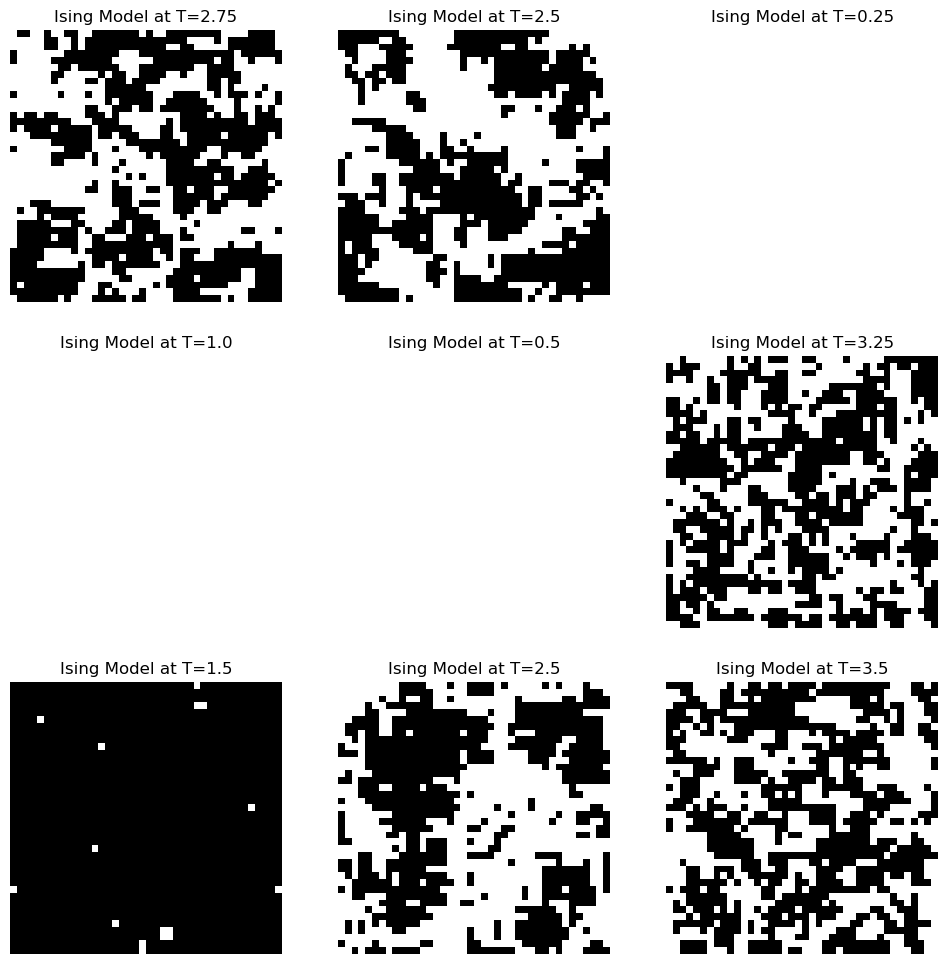

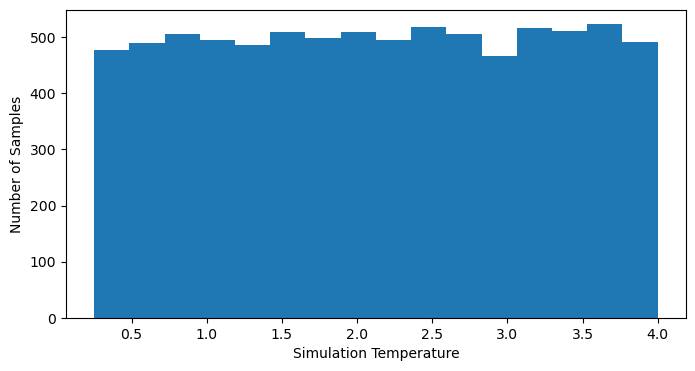

In [22]:


## Randomly subsample the data 

np.random.seed(0) # fix the random seed
idx = np.arange(len(X))
rand = np.random.choice(idx, size=8000, replace=False)

X_batch, y_batch = X[rand], y[rand]
print(f"X_batch shape: {X_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")

### make a panel of 3x3 images
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_batch[i].reshape(40, 40), cmap='binary')
    plt.title(f"Ising Model at T={y_batch[i]}")
    plt.axis('off')

plt.figure(figsize=(8, 4))
plt.hist(y_batch, bins=16);
plt.xlabel('Simulation Temperature');
plt.ylabel('Number of Samples');

# Embedding and dimensionality reduction

+ Our Ising model data lives in a feature space $d = 40^2 = 1600$ dimensions.
+ We want to visualize and analyze the data in a lower-dimensional space.

### Fit embeddings and plot the results

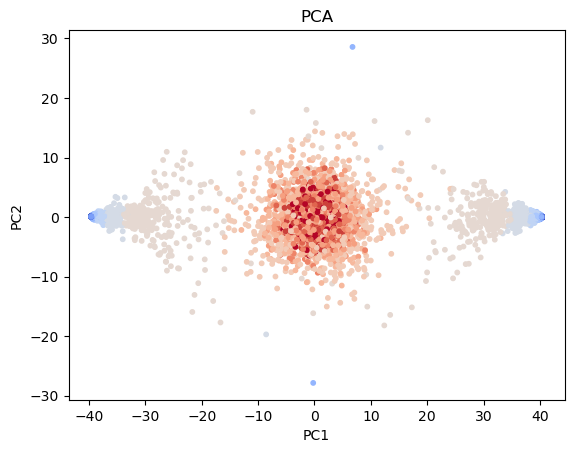

In [9]:
from sklearn.decomposition import PCA

## Fit PCA and t-SNE embedding methods
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_batch)
component1 = pca.components_[0]

## Plot the results
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_batch, s=10, cmap="coolwarm")
plt.gca().set_title("PCA")
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.show()

### Our results match recently published works...

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/wang preb 2016 header.png" alt="wang et al header" style="width: 750px;"/>
<br>
<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/wang preb 2016 fig 1.png" alt="wang et al pca ising" style="width: 750px;"/>


*Image from [Wang. Phys Rev B (2016)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.94.195105)*

### Other embedding techniques exploit nonlinear transformations

+ PCA finds a lower dimensional space that is a linear combination of input features

+ t-SNE and UMAP finds a lower dimensional space where each new variable is a nonlinear combination of input features. 

+ PCA maximizes the variance captured in the lower dimensional space

+ t-SNE and UMAP try to preserve the local structure of the data (like distributions of distances) in the lower dimensional space

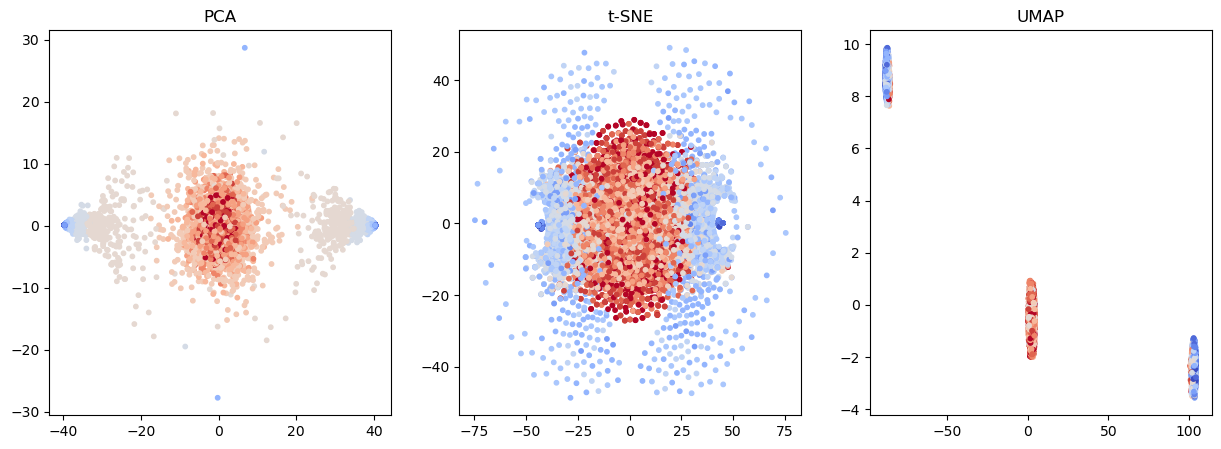

In [30]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

## Fit PCA and t-SNE embedding methods
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_batch)
component1 = pca.components_[0]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_batch)


umap = UMAP(n_components=2)
X_umap = umap.fit_transform(X_batch)

## Plot the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_batch, s=10, cmap="coolwarm")
ax[0].set_title("PCA")
ax[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_batch, s=10, cmap="coolwarm")
ax[1].set_title("t-SNE")
ax[2].scatter(X_umap[:, 0], X_umap[:, 1], c=y_batch, s=10, cmap="coolwarm")
ax[2].set_title("UMAP")
plt.show()

What physics can we learn from our unsupervised analysis? We can inspect PCA-1 principal component learned by the fitted model:

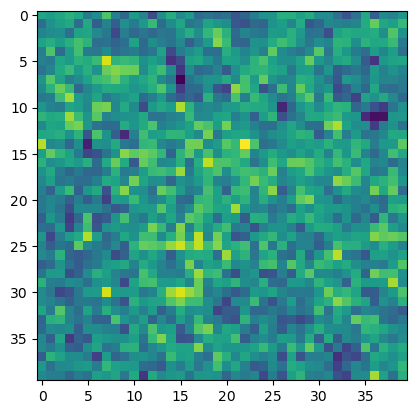

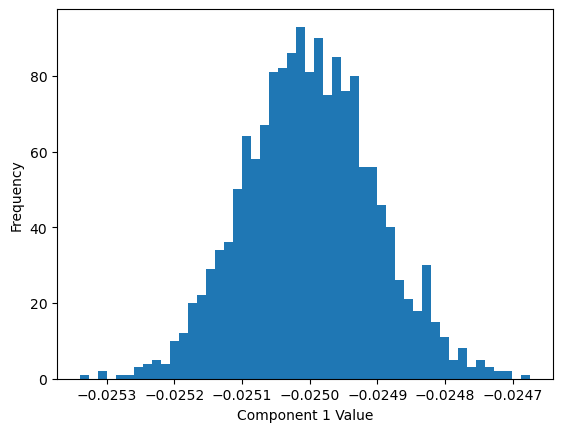

In [17]:

plt.figure()
plt.imshow(component1.reshape(40, 40))

plt.figure()
plt.hist(component1, bins=50)
plt.xlabel('Component 1 Value');
plt.ylabel('Frequency');

### Discussion

+ The components of the first PCA vector are tightly distributed around a single value. This implies that the PCA vector is essentially a constant vector. 

+ Indeed turns out that PC1 aligns strong with the magnetization order parameter. This is because PCA tends to find linear combinations of the features that have the largest variance, and the magnetization can be written as a linear combination of input features (the spins)

$$
M = \frac{1}{N} \sum_i^N s_i
$$

+ The magnetization represents the condition that was varied across simulations, so it makes sense that it would correspond to the highest variance component.

## Embeddings are widely used for exploratory data analysis

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/stephens_elegans.png" alt="elegans posture" style="width: 750px;"/>

Image from [Stephens et al 2008](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000028)

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/tabula_muris.png" alt="tabula muris" style="width: 750px;"/>

*Image from [Tabula Muris Consortium](https://www.nature.com/articles/s41586-018-0590-4)*

44,949 cells, ~20,000 genes per cell

# Automatically identifying phases using K means clustering

We will now use the $K$-means algorithm to cluster the Ising data. The $K$-means algorithm is a simple algorithm that is easy to implement and understand. It is also very fast. The algorithm is as follows:

1. Choose $K$ initial cluster centers
2. Assign each point to the nearest cluster center
3. Update the cluster centers to be the mean of the points in the cluster
4. Repeat steps 2 and 3 until the cluster centers do not change

The $K$-means algorithm is guaranteed to converge to a local minimum. However, the choice of initial cluster centers can lead to different results.

Unlike some other clustering methods, the KMeans algorithm requires that we specify the number of clusters $K$ in advance as a hyperparameter. However, there are external heuristics like the silhouette score that we cane use to determine the optimal number of clusters.

In [23]:
class KMeansClusterer:
    """
    An implementation of the K Means clustering algorithm.
    """

    def __init__(self, n_clusters=2, max_iter=100, tol=1e-4, store_history=False, random_state=None):
        """
        Initialize a KMeansClusterer object.

        Args:
            n_clusters (int): number of clusters to fit
            max_iter (int): maximum number of iterations to run
            tol (float): tolerance for convergence
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.store_history = store_history
        self.random_state = random_state

    def fit(self, X):
        """
        Fit the KMeans clustering algorithm to the data.

        Args:
            X (np.array): 2D array of shape (N, D) containing the data to cluster

        Returns:
            self (KMeansClusterer): the fitted KMeansClusterer object
        """
        N, D = X.shape

        ## Initialize the cluster centers and assign all points to the first cluster
        if self.random_state is not None:
            np.random.seed(self.random_state)
        self.centers = np.random.choice(N, size=self.n_clusters, replace=False)
        self.centers = X[self.centers]
        self.labels = np.zeros(N)

        if self.store_history:
            self.history = []
            self.loss_history = []
            self.label_history = []

        for i in range(self.max_iter):

            ## Assign each point to the nearest cluster center
            distortion = np.sum((X[:, np.newaxis, :] - self.centers[np.newaxis, :, :]) ** 2, axis=2)
            self.labels = np.argmin(distortion, axis=1)

            if self.store_history:
                self.history.append(self.centers)
                self.loss_history.append(np.mean(np.min(distortion, axis=1)))
                self.label_history.append(self.labels.copy())

            ## Update the cluster centers based on the latest assignments
            new_centers = np.array([np.mean(X[self.labels == j], axis=0) for j in range(self.n_clusters)])

            ## Stop if the centers have converged
            if np.sum((new_centers - self.centers) ** 2) < self.tol:
                print("Converged after {} iterations".format(i))
                break
            self.centers = new_centers

        return self

    def predict(self, X):
        """
        Predict the labels of the data.

        Args:
            X (np.array): 2D array of shape (N, D) containing the data to cluster

        Returns:
            labels (np.array): 1D array of shape (N,) containing the predicted labels
        """
        return np.argmin(np.sum((X[:, np.newaxis, :] - self.centers[np.newaxis, :, :]) ** 2, axis=2), axis=1)

    def fit_predict(self, X):
        """
        Fit the KMeans clustering algorithm to the data and predict the labels.

        Args:
            X (np.array): 2D array of shape (N, D) containing the data to cluster

        Returns:
            labels (np.array): 1D array of shape (N,) containing the predicted labels
        """
        self.fit(X)
        return self.predict(X)
        
        

Text(0.5, 1.0, 'PCA embedding of Ising data before clustering')

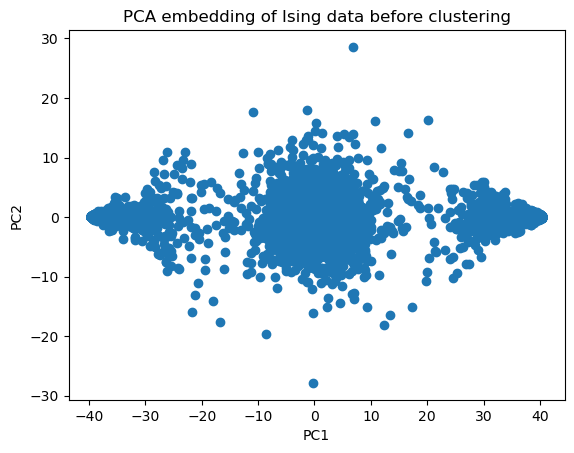

In [24]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.title('PCA embedding of Ising data before clustering')

Converged after 4 iterations


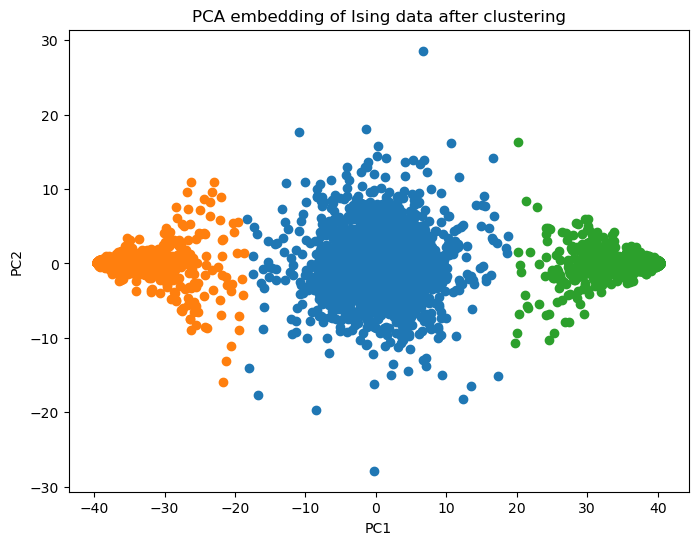

Text(0, 0.5, 'Loss (Inertia)')

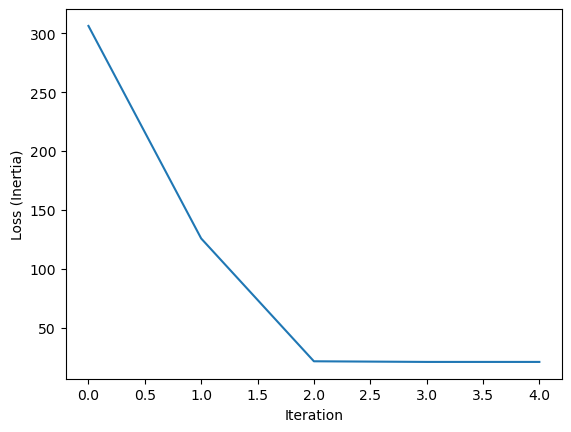

In [25]:
model = KMeansClusterer(n_clusters=3, max_iter=100, tol=1e-4, store_history=True, random_state=14)
labels = model.fit_predict(X_pca)

plt.figure(figsize=(8, 6))
for label_val in np.unique(labels):
    plt.scatter(X_pca[labels==label_val, 0], X_pca[labels==label_val, 1])
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.title('PCA embedding of Ising data after clustering')
plt.show()

plt.figure()
plt.plot(model.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss (Inertia)')


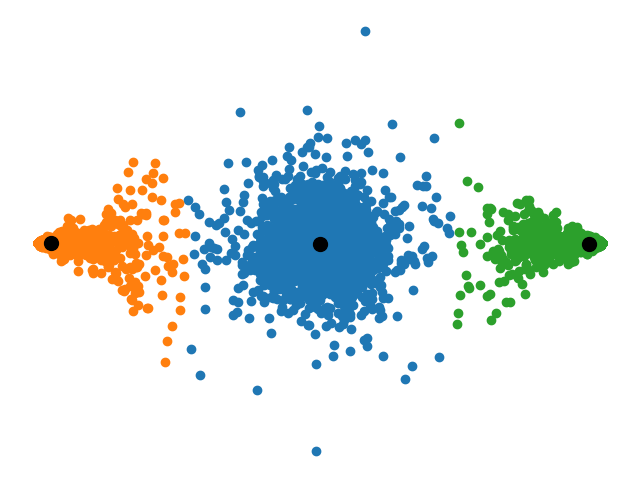

In [26]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(8, 6))

def init():
    return []

def update(i):
    ax.clear()
    labels = model.label_history[i]
    for label_val in np.unique(labels):
        ax.scatter(X_pca[labels == label_val, 0], X_pca[labels == label_val, 1])
    ax.plot(*model.history[i].T, '.k', markersize=20)
    ax.axis('off')
    return []

ani = FuncAnimation(fig, update, frames=range(len(model.history)), init_func=init, blit=True)

# Show as HTML video
HTML(ani.to_jshtml())

### Are the observed clusters physically meaningful?

Let's now look at the mean of each cluster. Since we have obtained the cluster labels, we can go back to the original space, rather the lower dimensional PCA space that we have been working in so far

In [38]:
[np.mean(X_batch[labels==label_val]) for label_val in [0, 1, 2]]

[0.0010270856662933931, 0.9540760869565217, -0.9555427782888685]

Thus we found that left- and right-most clusters are well magnetized (ordered phase). The middle cluster is not magnetized and corresponds to the high-temperature states.

# Clustering accuracy and clustering algorithm parameters:

+ We want to use clustering to explore datasets where we don't have labels. However, for the Ising dataset, we do have labels in the form of temperatures at which simulations were completed. 

1. Can we use these labels to define what a good cluster or a good clustering assignment is?

2. For cases where we don't have access to labels, how would we determine if a clustering algorithm is doing a good job?


+ One way to quantitatively measure the performance of a clustering method is to compare the predicted labels to the ground-truth labels (given that those are available). Here we will use [the normalized mutual information](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html).

$$
\text{NMI}(y_{\text{true}}, y_{\text{pred}}) = \frac{2 \times I(W, C)}{H(W) + H(C)}
$$ 

where a clustering $W = \{w_1, w_2, ..., w_N\}$ and the ground-truth $C = \{c_1, c_2, ..., c_M\}$ are sets of sets of indices. For example, if datapoints $1, 7, 31$ all have the same true label $0$, then $c_1 = \{1, 7, 31\}$. The mutual information $I(W, C)$ is defined as

$$
I(W, C) = \frac{1}{N} \sum_{w \in W} \sum_{c \in C} |w \cap c| \log \left( \frac{N \times |w \cap c|}{|w| \times |c|} \right)
$$

+ As we will see, when doing clustering, there is usually no free lunch: if one chooses the wrong set of parameters (which can be quite sensitive), the clustering algorithm will likely fail or return a trivial answer (for instance all points assigned to the same cluster).  

In [11]:
from collections import OrderedDict

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.0
    for kc in c.keys():
        p=len(c[kc]) / n_sample
        h += p * np.log(p)
    h *= -1.0
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c * np.log(n_sample * w_intersect_c/(len(w[kw]) * len(c[kc])))
    Iwc /= n_sample
    Hc = entropy(c, n_sample)
    Hw = entropy(w, n_sample)

    return 2 * Iwc / (Hc + Hw)

## Try other clustering methods

This code is adapted from [the scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)

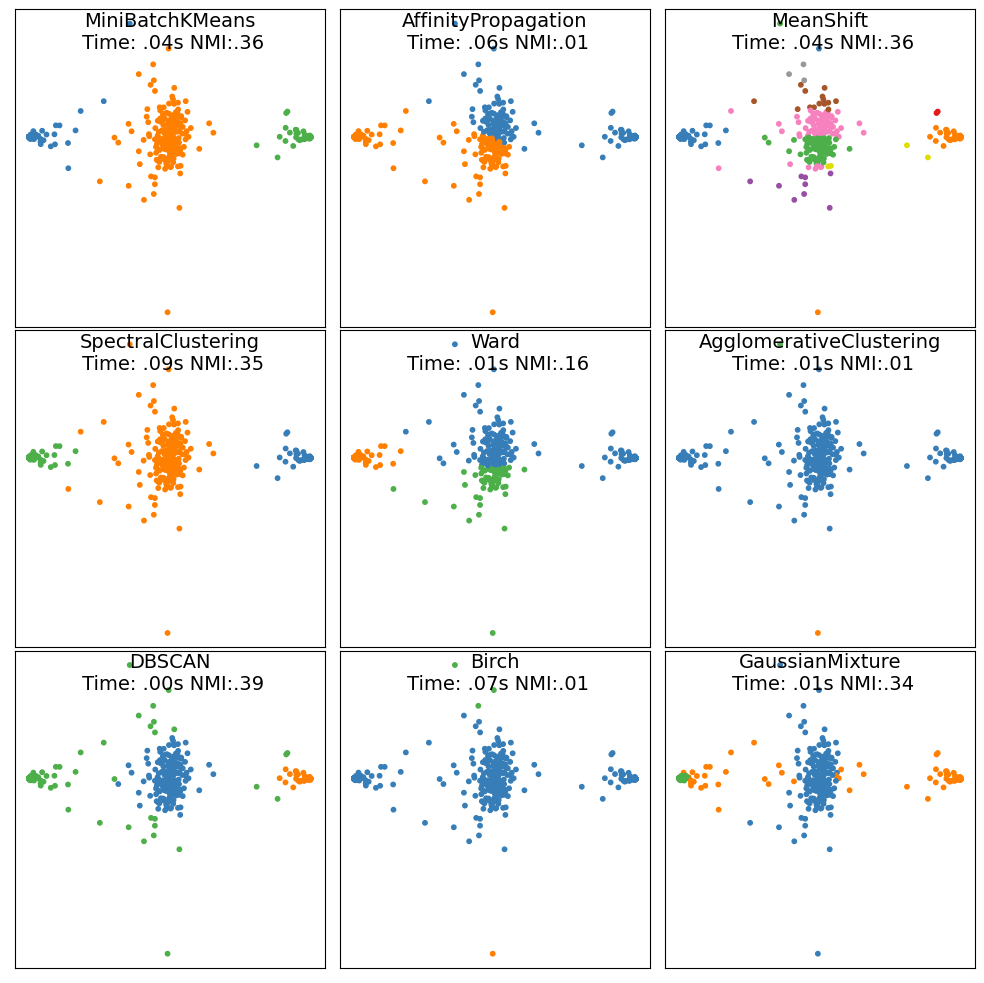

In [13]:
import time
import warnings


from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice


np.random.seed(0)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

algo_params = {'damping': .9, 'preference': -240, 'quantile': .2, 'n_clusters': 3}
i_dataset = 0

# for i_dataset, (dataset, algo_params) in enumerate(datasets):

# update parameters with dataset-specific values
params = default_base.copy()
params.update(algo_params)

X_batch, y_batch = X_pca[:400], y_batch[:400]
# y_batch = tt

# normalize dataset for easier parameter selection
X_batch = StandardScaler().fit_transform(X_batch)

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X_batch, quantile=params['quantile'])

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X_batch, n_neighbors=params['n_neighbors'], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(
    n_clusters=params['n_clusters'], linkage='ward',
    connectivity=connectivity)
spectral = cluster.SpectralClustering(
    n_clusters=params['n_clusters'], eigen_solver='arpack',
    affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=params['eps'])
affinity_propagation = cluster.AffinityPropagation(
    damping=params['damping'], preference=params['preference'])
average_linkage = cluster.AgglomerativeClustering(
    linkage="average", affinity="cityblock",
    n_clusters=params['n_clusters'], connectivity=connectivity)
birch = cluster.Birch(n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture(
    n_components=params['n_clusters'], covariance_type='full')

clustering_algorithms = (
    ('MiniBatchKMeans', two_means),
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm)
)

for i, (name, algorithm) in enumerate(clustering_algorithms):
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X_batch)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X_batch)

    score = NMI(y_batch, y_pred)

    # if i_dataset == 0:
    #     plt.title(name, size=14)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                            '#f781bf', '#a65628', '#984ea3',
                                            '#999999', '#e41a1c', '#dede00']),
                                    int(max(y_pred) + 1))))

    plt.subplot(3, 3, i+1)

    plt.scatter(X_batch[:, 0], X_batch[:, 1], s=10, color=colors[y_pred])
    plt.xticks(())
    plt.yticks(())

    plt.title(name + "\n Time: " + ("%.2fs" % (t1 - t0)).lstrip("0") + " NMI:" + ("%.2f" % score).lstrip("0"), size=14, y=1.0, pad=-28)

# plt.show()

# Remarks and discussion

We can see that the NMI doesn't perfectly match our expectations. It rewards algorithms that assign more labels than are necessary to fully describe the dataset. For this reason, other metrics like the silhouette score or the adjusted rand index are sometimes used instead.

In this simple setting, DBSCAN outperforms the other methods both in computational time and in prediction accuracy for almost all cases. Only Spectral Clustering appears to perform better on the PCA-featurized Ising dataset. 

When tuning a clustering method it is important to understand what the implicit assumption of the clustering method are. For instance, methods based on density (local information), will typically fare well at clustering topological datasets, in which there is a distance metric relating different datapoints. Methods based on long-distance information ($K$-means for instance), will typically perform poorly in such instances. Density-based methods will, however, have more difficulty dealing with datasets with large fluctuations in the density distribution of the dataset. Another drawback of density based methods is that they do not generalize well to high-dimensional space due to large sampling noise in the density estimates. 

# How do we choose the number of clusters?

+ For our Ising dataset, we knew to pick $K = 3$ because we knew the ground truth number of states.
+ In general, we don't have the ground truth. How do we choose the number of clusters in a principled way?


## Silhouette score

The silhouette score is a measure of how well a datapoint fits into its assigned cluster. It is defined as:

$$
s_i = \frac{b_i - a_i}{\max(a_i, b_i)}
$$

where $a_i$ is the average distance between $i$ and all other points in the same cluster, and $b_i$ is the smallest average distance between $i$ and all points in any other cluster. The silhouette score is bounded between -1 and 1, with 1 indicating that the datapoint is well within its cluster, and -1 indicating that the datapoint is poorly assigned to its cluster.


## Elbow method

The elbow method is a heuristic that attempts to find the optimal number of clusters by looking for the "elbow" in the plot of the silhouette score as a function of the number of clusters. The intuition is that the silhouette score will increase as the number of clusters increases, but at some point the increase will slow down. This is the "elbow" of the curve. The optimal number of clusters is the number of clusters at the elbow.

This approach is very similar to how we determined the appropriate number of principal components to include in our PCA analysis.

## Gap statistic

The gap statistic is a heuristic that attempts to find the optimal number of clusters by looking for the "gap" in the plot of the log of the within-cluster sum of squares as a function of the number of clusters. The intuition is that the within-cluster sum of squares will decrease as the number of clusters increases, but at some point the decrease will slow down. This is the "gap" of the curve. The optimal number of clusters is the number of clusters at the gap.

## Discussion

The elbow method and the gap statistic are heuristics that attempt to find the optimal number of clusters. There are other metrics that we can imagine using instead of the silouette score, such as the distortion (the kmeans error metric, which determined cluster purity). For these other metrics, we can still use the elbow method or the gap statistic to find the optimal number of clusters.


Hierarchical clustering: number of clusters depends on the resolution at which we want to analyze the data.

In [40]:
# Silouhette score

def pairwise_distances(X, Y=None, metric='euclidean'):
    """
    Compute pairwise distance matrix between two arrays.
    
    Args:
        X (array-like): array of shape (n_samples, n_features)
        Y (array-like): array of shape (n_samples, n_features)

    Returns:
        D (array-like): array of shape (n_samples, n_samples)
    """
    if Y is None:
        Y = X
    return np.sqrt(((X[:, None, :] - Y[None, :, :]) ** 2).sum(axis=2))

def silhouette_score(X, labels):
    """Compute the mean Silhouette Coefficient of all samples."""
    unique_labels = np.unique(labels)
    centroids = np.array([X[labels == i].mean(axis=0) for i in unique_labels])
    a = np.array([np.mean(pairwise_distances(X[labels == i], centroids[unique_labels == i], metric='euclidean')) for i in unique_labels])
    b = np.array([np.mean(pairwise_distances(X[labels == i], centroids[unique_labels != i], metric='euclidean')) for i in unique_labels])
    return np.mean((b - a) / np.maximum(a, b))



model = KMeansClusterer(n_clusters=3, max_iter=100, tol=1e-4, store_history=True, random_state=14)
labels = model.fit_predict(X_pca)

silhouette_score(X_pca, labels)

Converged after 4 iterations


0.9336671341105957

### We vary $K$ in the range $[2, 10]$ and plot the silhouette score as a function of $K$

Converged after 3 iterations
Converged after 4 iterations
Converged after 25 iterations
Converged after 21 iterations
Converged after 15 iterations
Converged after 22 iterations
Converged after 52 iterations
Converged after 39 iterations
Converged after 37 iterations


Text(0, 0.5, 'Silhouette score')

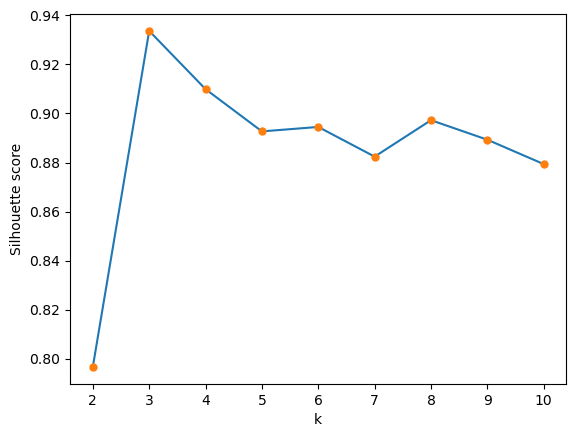

In [41]:

all_silouette_scores = []
kvals = np.arange(2, 11)
all_labels = list()
for k in kvals:
    model = KMeansClusterer(n_clusters=k, max_iter=100, tol=1e-4, store_history=True, random_state=14)
    labels = model.fit_predict(X_pca)
    all_silouette_scores.append(silhouette_score(X_pca, labels))
    all_labels.append(labels.copy())


plt.plot(kvals, all_silouette_scores, '-')
plt.plot(kvals, all_silouette_scores, '.', markersize=10)
plt.xlabel('k')
plt.ylabel('Silhouette score')


## Overfitting versus underfitting

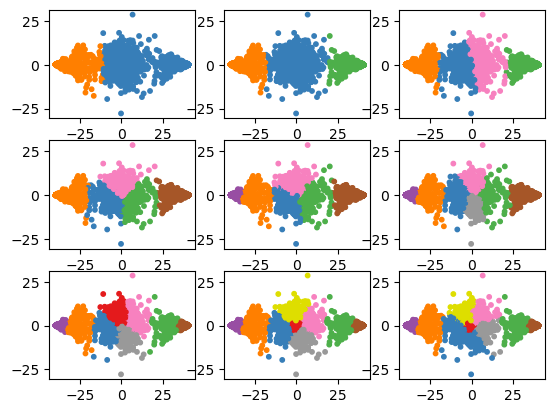

In [26]:
from itertools import cycle, islice
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                            '#f781bf', '#a65628', '#984ea3',
                                            '#999999', '#e41a1c', '#dede00']),
                                    int(max(kvals) + 1))))
for i in range(len(kvals)):

    plt.subplot(3, 3, i+1)

    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, color=colors[all_labels[i]])

# Appendix

+ Leftover code from this tutorial

In [47]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    plt.figure(figsize=(8, 6))
    labels = model.label_history[i]
    for label_val in np.unique(labels):
        plt.scatter(X_pca[labels==label_val, 0], X_pca[labels==label_val, 1])
    plt.plot(*model.history[i].T, '.k', markersize=20)
    plt.axis('off')
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(model.history) - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=4), Output()), _do…

<function __main__.plotter(i)>